In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn', 'recall1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 4002.59 seconds 
duration: 1.11 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 124.4 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,24.0672,25.9024,None,1.8352
1,91.8944,123.9360,None,32.0416
2,131.7952,132.6608,None,0.8656
3,144.3256,151.7920,None,7.4664
4,203.8240,210.6336,None,6.8096
5,211.3012,211.8252,None,0.5240
6,218.6744,222.6064,None,3.9320
7,259.6192,260.7936,None,1.1744
8,272.0784,272.3000,None,0.2216
9,272.8732,273.2140,None,0.3408


<Axes: >

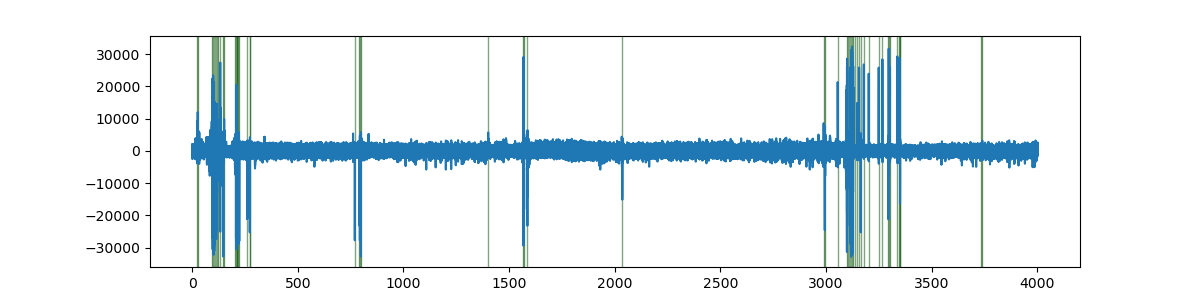

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.probegroup.npy saved


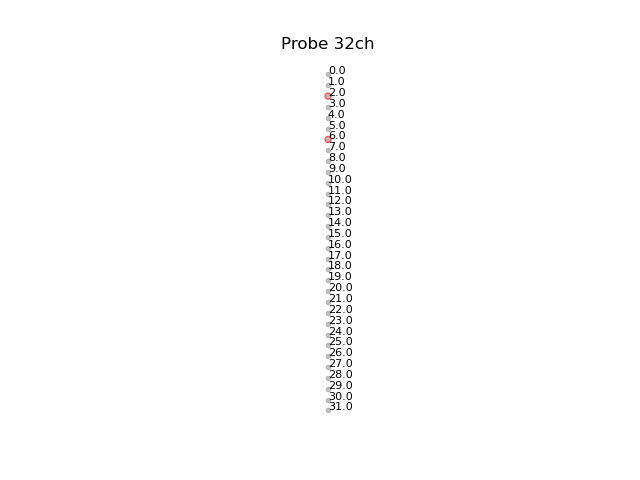

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [24]
327 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.theta_epochs.npy saved


## Detect SWR Epochs

In [9]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 24
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [24]
1995 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.ripple_epochs.npy saved


## Delta

In [10]:
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 24  

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)
sess.recinfo.write_epochs(delta_epochs, ext='dta')
delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs.save(delta_epochs_file)

159 delta waves detected
/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.delta_epochs.npy saved


## Beta

In [11]:
#Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 24
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(beta_epochs, ext='bta')
beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs.save(beta_epochs_file)

Best channel for beta: [24]
325 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.beta_epochs.npy saved


## Gamma

In [12]:
# Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 0.5 
highthresh = 5
minDistance = 20
minDuration = 20
gamma_channel = 24

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
sess.recinfo.write_epochs(gamma_epochs, ext='gma')
gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs.save(gamma_epochs_file)


/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.gamma_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [13]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

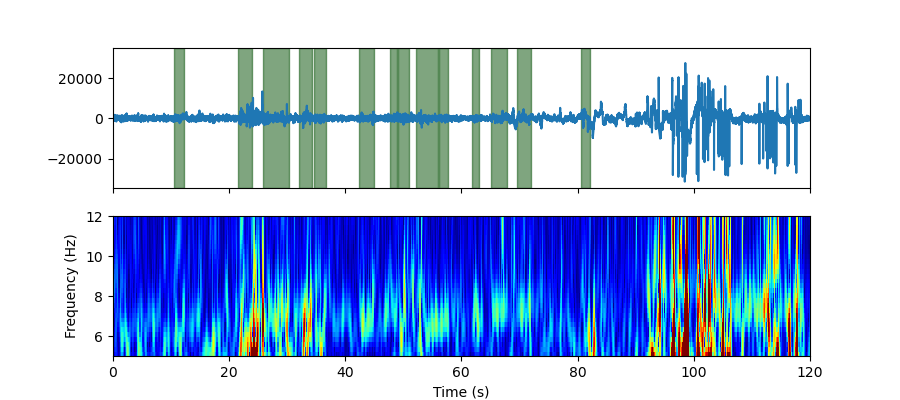

In [14]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

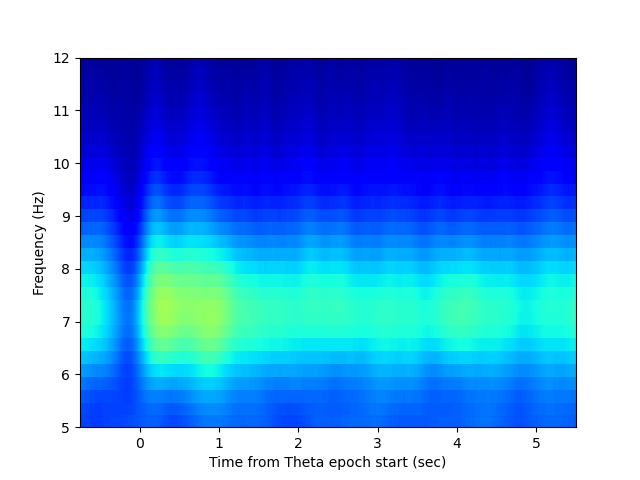

In [15]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [16]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

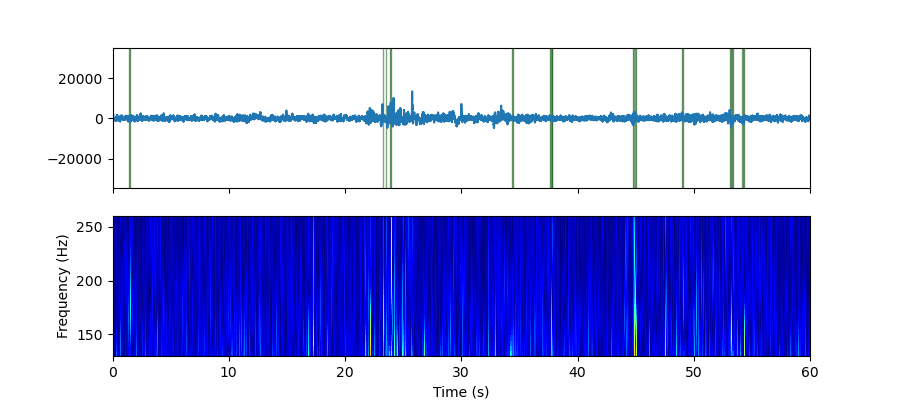

In [17]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

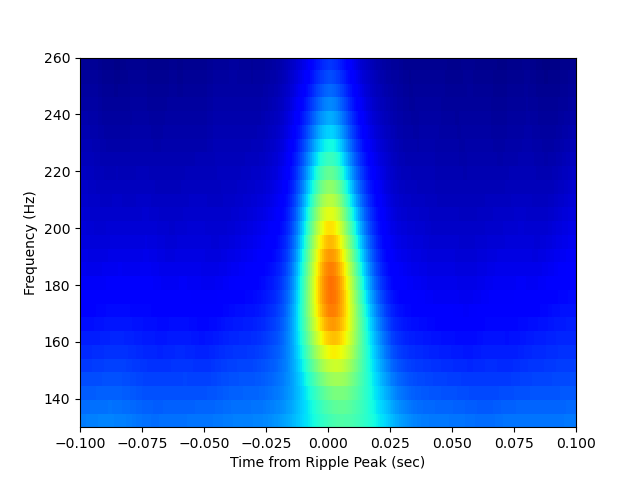

In [18]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-USV analyses

In [19]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

203 epochs
Snippet: 
          start         stop   Begin_Time  Freq_Min  Duration  Freq_Range  \
0  1016.930199  1019.321947  1202.743826    15.750  2.392077         6.5   
1  1021.038342  1022.978082  1206.852534    15.625  1.940006         5.5   
2  1023.171727  1024.560180  1208.986212    16.000  1.388644         7.0   
3  1024.772570  1026.313028  1210.587275    16.000  1.540670         7.0   
4  1026.491271  1027.771154  1212.306212    16.000  1.280059         7.0   

      Score  Accept label  
0  0.555882       1        
1  0.574933       1        
2  0.589289       1        
3  0.589289       1        
4  0.589289       1        

In [20]:
usv_epochs._epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,1016.930199,1019.321947,1202.743826,15.750000,2.392077,6.500000,0.555882,1,
1,1021.038342,1022.978082,1206.852534,15.625000,1.940006,5.500000,0.574933,1,
2,1023.171727,1024.560180,1208.986212,16.000000,1.388644,7.000000,0.589289,1,
3,1024.772570,1026.313028,1210.587275,16.000000,1.540670,7.000000,0.589289,1,
4,1026.491271,1027.771154,1212.306212,16.000000,1.280059,7.000000,0.589289,1,
...,...,...,...,...,...,...,...,...,...
198,1376.156283,1377.210956,1562.019267,17.792658,1.054818,4.979317,1.000000,1,
199,1377.341869,1378.193208,1563.205016,16.686143,0.851456,6.307135,1.000000,1,
200,1378.307864,1379.199808,1564.171144,18.567218,0.892067,4.979317,1.000000,1,
201,1379.307889,1379.910400,1565.171306,15.911582,0.602594,9.294726,1.000000,1,


In [21]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<0.6]
short_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
49,1108.250483,1108.798070,1294.076657,16.796794,0.547663,8.188211,1.000000,1,
54,1124.965406,1125.183040,1310.793877,16.453591,0.217664,6.857459,1.000000,1,
91,1181.932828,1182.487352,1367.769126,14.639090,0.554600,9.460703,1.000000,1,
117,1226.911793,1227.424007,1412.754272,18.235264,0.512283,7.192347,1.000000,1,
123,1236.142582,1236.723158,1421.986329,19.341779,0.580655,5.200620,1.000000,1,
132,1247.462557,1247.614163,1433.307858,18.677870,0.151628,5.643226,1.000000,1,
139,1260.154022,1260.695115,1446.001068,18.500000,0.541167,6.000000,0.521935,1,
144,1270.173102,1270.681855,1456.021524,17.399448,0.508823,7.330387,1.000000,1,
166,1297.578767,1298.082290,1483.430955,18.677870,0.503592,6.749741,1.000000,1,
176,1326.225810,1326.805434,1512.081933,17.635912,0.579704,7.017139,1.000000,1,


In [22]:
short_usv_epochs.Duration.mean()

0.44821792326761817

In [23]:
long_usv_epochs= usv_epochs._epochs[(usv_epochs._epochs.Duration>1.5)]
long_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,1016.930199,1019.321947,1202.743826,15.750000,2.392077,6.500000,0.555882,1,
1,1021.038342,1022.978082,1206.852534,15.625000,1.940006,5.500000,0.574933,1,
3,1024.772570,1026.313028,1210.587275,16.000000,1.540670,7.000000,0.589289,1,
6,1032.152357,1033.991513,1217.968076,15.911582,1.839408,8.962771,1.000000,1,
11,1042.863634,1044.541022,1228.680825,16.500000,1.677618,6.625000,0.620000,1,
17,1054.417878,1056.475435,1240.236656,15.500000,2.057840,8.250000,0.568452,1,
25,1066.967694,1068.562345,1252.788196,15.034807,1.594871,9.507593,1.000000,1,
34,1080.119711,1082.012934,1265.942020,16.000000,1.893483,7.875000,0.572339,1,
40,1092.515444,1094.096987,1278.339456,16.000000,1.581761,7.250000,0.645426,1,
44,1101.836095,1103.613177,1287.661388,15.625000,1.777326,8.875000,0.593512,1,


In [24]:
long_usv_epochs.Duration.mean()

1.749943778064835

In [25]:
usv_epochs._epochs.Duration.mean()

1.0120961104160453

# Delta

In [26]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

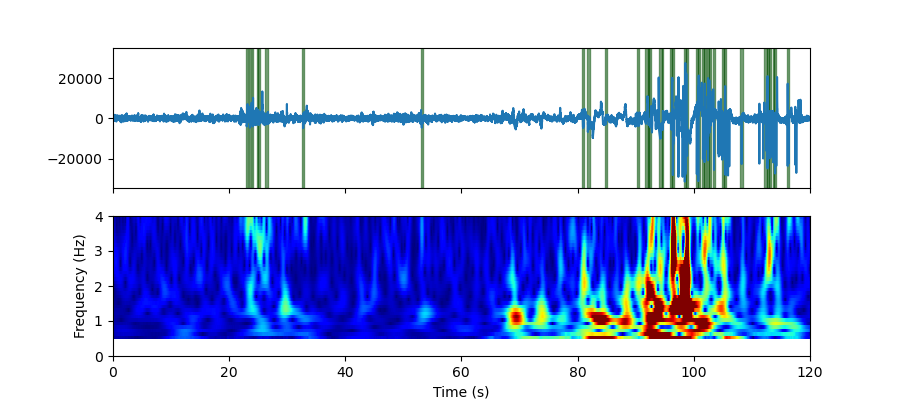

In [27]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
delta_freq_lims = [0.5, 4]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

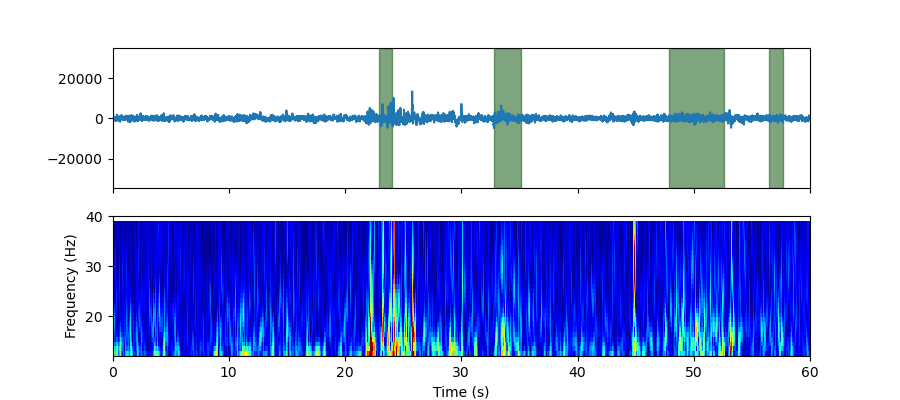

In [28]:
## Beta
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

In [29]:
#Gamma
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

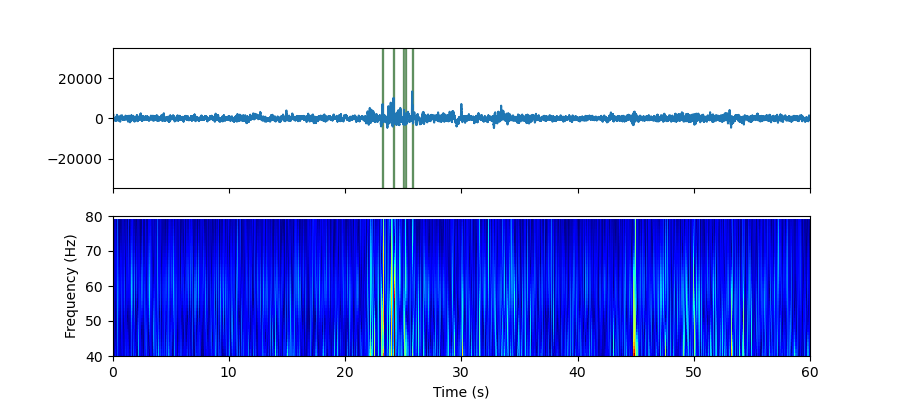

In [30]:
#Gamma
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start(sec)')

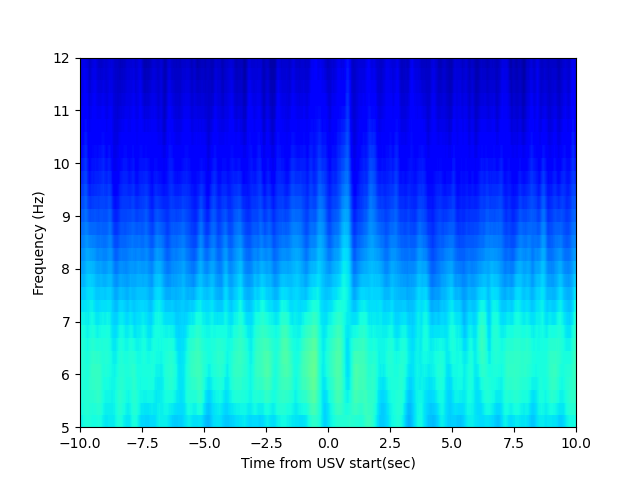

In [31]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV stop(sec)')

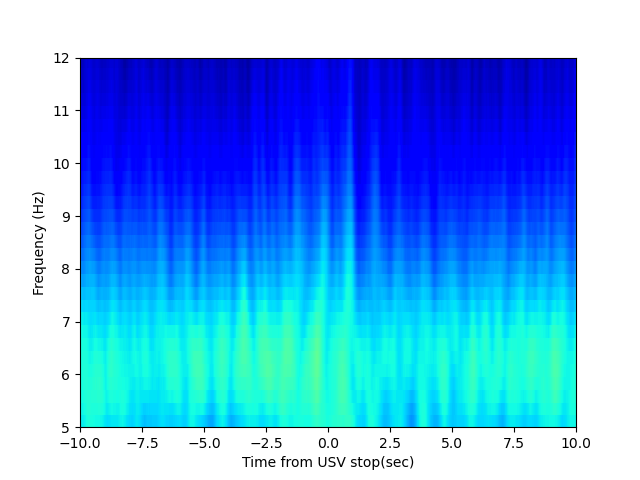

In [32]:
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['stop'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV stop(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start(sec)')

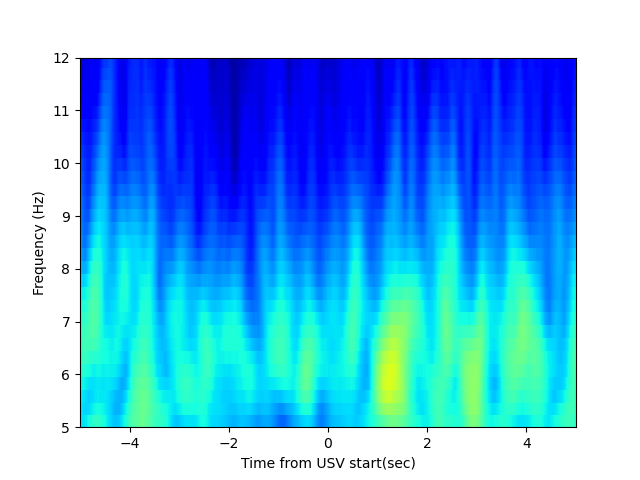

In [33]:
# Long USVs
usv_buffer_sec = (5, 5)
wv_theta_mean_long = wv_theta.get_pe_mean_spec(long_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_theta_mean_long, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start (sec)')

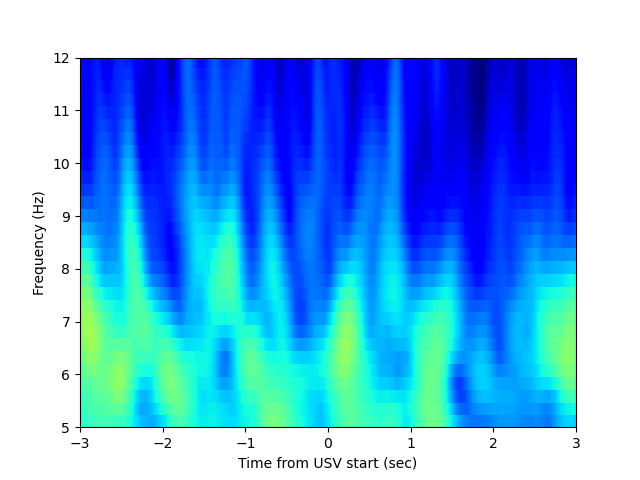

In [34]:
# short usv
usv_buffer_sec = (3, 3)
wv_theta_mean_short = wv_theta.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean_short, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

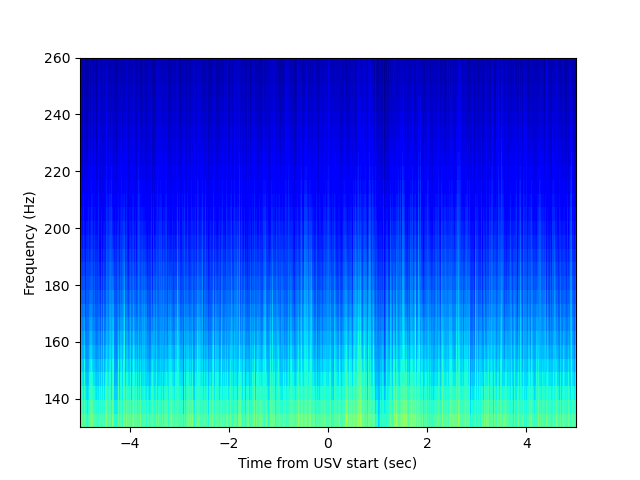

In [35]:
# All
usv_buffer_sec = (5,5)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

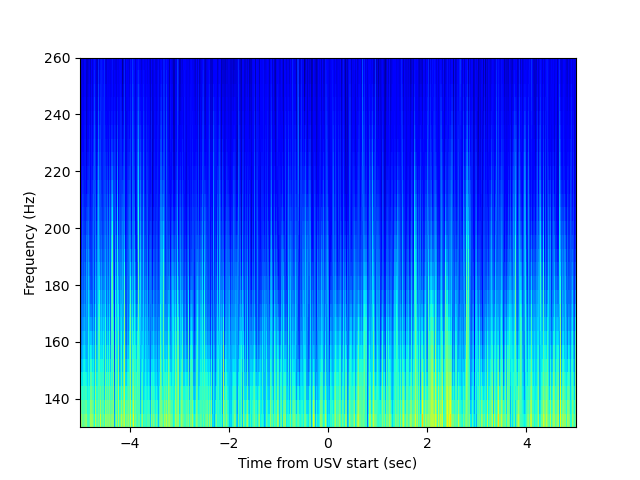

In [36]:
#long USV ripple
usv_buffer_sec = (5, 5)
wv_swr_mean = wv_swr.get_pe_mean_spec(long_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

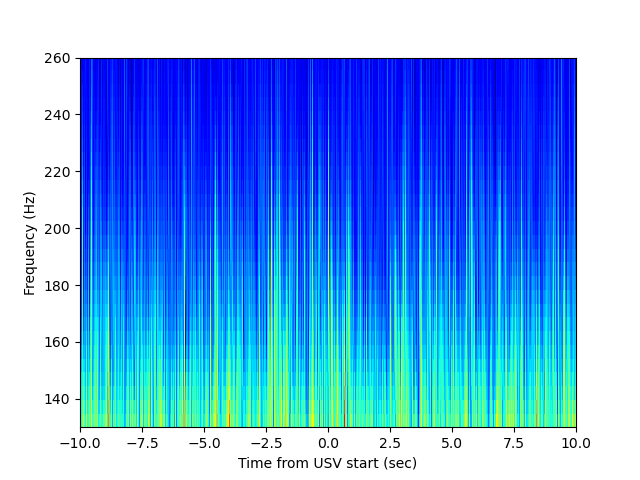

In [37]:
#short
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Delta

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

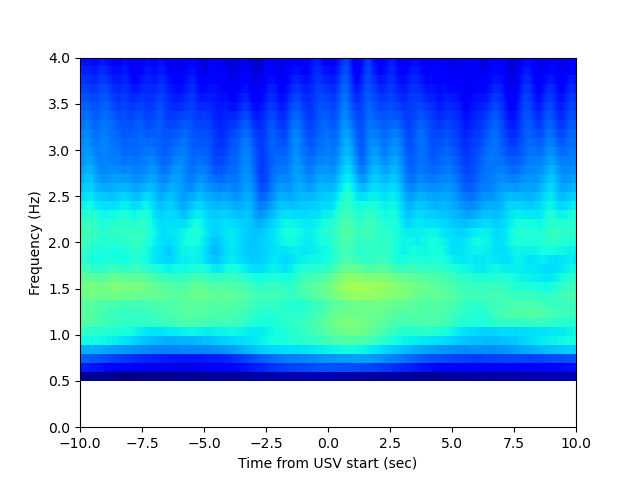

In [38]:
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)

# Ensure the limits for the spectrogram are valid
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

plt.show()

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

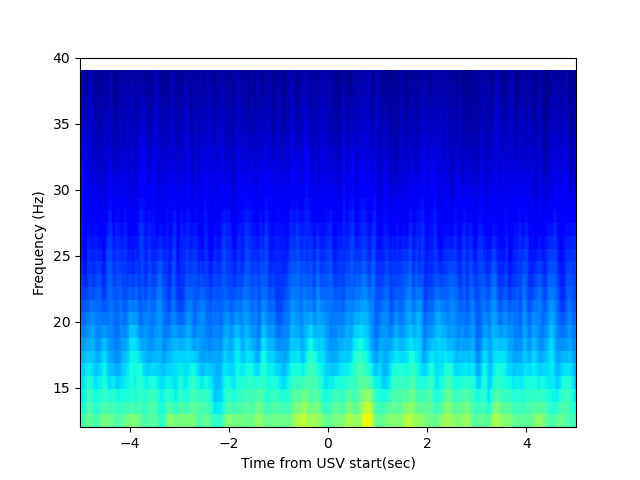

In [39]:
#Beta
usv_buffer_sec = (5, 5)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

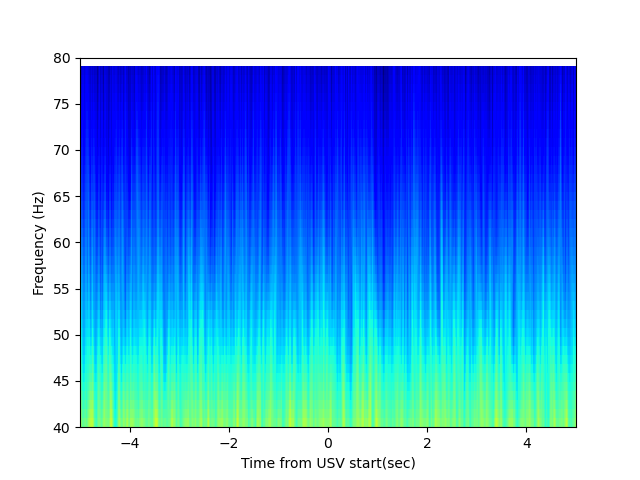

In [40]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Finn recall7 note:
pyr channel (26) has weird-looking oscillations particularly during CS- and CS+(2) times.  I have used channel 20 instead which is well above the cell layer but has good-looking volume-conducted theta.  SWR detection appears to be fine using ch 26.

## Save notebook to working directory

In [41]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Animal_files/Training notebooks/USV_Spectral_Analysis(Finn).ipynb saved to /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_USV_Spectral_Analysis(Finn).ipynb


In [ ]:
pip install jupyter-save-load-vars